# SET: 23-9-15


In [47]:
# Importing standard data analysis and visualization libraries
import pandas as pd  # For data manipulation and analysis
import seaborn as sns  # For advanced data visualization
import matplotlib.pyplot as plt  # For basic plotting and visualization
from scipy.stats import ttest_ind, mannwhitneyu  # For statistical tests
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Importing custom utility functions for specific data processing tasks
from Utils_ipynb import (
    append_csv_files_from_subfolders,  # Function to concatenate CSV files from subfolders
    extract_and_append_image_info,  # Function to extract and append image information from data
    filter_dataframe,  # Function to filter data based on specific criteria
    get_correlation_matrices_plt,  # Function to create and plot correlation matrices
    refine_and_filter_data , # Function to refine and further filter data
    plot_metrics_by_group_and_ring
)

# Settings

In [48]:
RING_COEFF_CUT_OFF = 1.2

## Data Preparation

### Step 1: Data Read
- **Objective**: Combine 'cell_stat.csv' files from various subdirectories within a specified root folder into a single DataFrame.
- **Context**: This step aggregates data collected from parallel analyses conducted on the Borah cluster.
- **Data Format**: Each 'cell_stat.csv' file contains [brief description of data, like columns and typical values].
- **Note**: [Any specific filters or considerations applied during aggregation, if applicable].



In [49]:
# Read files from each subdirctory
root_folder = r'C:\Users\nnina\Documents\BioLab_C\Current_experiments_C\Anamaria_3d_experiment_C\23-9-15_v2\analysis_data'
combined_df = append_csv_files_from_subfolders(root_folder)
combined_df.columns

Index(['Image_name', 'Img_num', 'Cell_num', 'Nucleus_volume, cubic_micrometre',
       'Nucleus_cylinder, pixels_number', 'Nucleus_length, micrometre',
       'Nucleus_width, micrometre', 'Nucleus_high, micrometre',
       'Cy5-T1 av_signal_in_nuc_area_3D', 'Cy5-T1 sum_pix_in_nuc_cylinder',
       'Cy5-T1 has ring', 'Cy5-T1 ring intensity coef',
       'AF594-T2 av_signal_in_nuc_area_3D', 'AF594-T2 sum_pix_in_nuc_cylinder',
       'AF594-T2 has ring', 'AF594-T2 ring intensity coef',
       'AF488-T3 av_signal_in_nuc_area_3D', 'AF488-T3 sum_pix_in_nuc_cylinder',
       'AF488-T3 has ring', 'AF488-T3 ring intensity coef'],
      dtype='object')

#### Step 2: Extraction of Experimental Setup and Group Information from Image Names
Extraction detailed information about the experimental setup and group, as well as the processing type, directly from the 'Image_name' column in our DataFrame. This is achieved through the extract_and_append_image_info function. The 'Image_name' column is a rich source of data, encapsulating key aspects of the experiment and image processing in a condensed format:
- Processing: Indicates the type of image processing used, such as 'RAW' or 'LSM'.
- Date: The date when the image was captured.
- Time: Time point of the experiment, typically 0, 24, or 48 hours.
- Cell Type: Identifies the cell type, e.g., 'KASH', 'KASH+doxy', or 'MSC'.
- LIV: Indicates the presence (+LIV) or absence (-LIV) of LIV in the sample.
- Cisp: Shows the concentration of Cisplatin used, or 'Control' if not applicable.

In [50]:
enhanced_df = extract_and_append_image_info(combined_df, 'Image_name')


In [51]:
# Define the columns to keep
columns_to_keep = [
    'Base_image_name', 'Time', 'Cell Type', 'LIV', 'Cisp', 'Cell_num',
    'Nucleus_volume, cubic_micrometre', 'Cy5-T1 av_signal_in_nuc_area_3D',
    'Cy5-T1 ring intensity coef', 'AF594-T2 av_signal_in_nuc_area_3D',
    'AF594-T2 ring intensity coef', 'AF488-T3 av_signal_in_nuc_area_3D',
    'AF488-T3 ring intensity coef'
]

# Ensure all listed columns exist in the DataFrame before selecting them
if all(col in enhanced_df.columns for col in columns_to_keep):
    # Select the columns
    filtered_df = enhanced_df[columns_to_keep]

    # Rename 'Base_image_name' to 'Image_name'
    filtered_df = filtered_df.rename(columns={'Base_image_name': 'Image_name'})

filtered_df

,Image_name,Time,Cell Type,LIV,Cisp,Cell_num,"Nucleus_volume, cubic_micrometre",Cy5-T1 av_signal_in_nuc_area_3D,Cy5-T1 ring intensity coef,AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,AF488-T3 ring intensity coef
0,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-03,0,KASH+doxy,+LIV,10um,0,387.682845,3405.715272,0.857249,1689.550044,1.092949,3814.849142,1.020733
1,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-03,0,KASH+doxy,+LIV,10um,1,367.317144,3339.179969,0.742296,2141.105358,1.412558,3625.255595,1.008106
2,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-03,0,KASH+doxy,+LIV,10um,2,403.430867,6057.918194,0.868496,1255.889380,1.404714,4669.589501,1.048670
3,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-03,0,KASH+doxy,+LIV,10um,3,381.680944,5947.099493,0.853258,1462.962593,1.534575,4695.707357,1.084201
4,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-12,0,KASH+doxy,+LIV,10um,0,931.329421,6456.557030,0.841100,158.139155,0.922989,4797.999470,1.032042
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-08,48,MSC,+LIV,10um,2,404.474025,4018.647594,0.842261,130.744368,0.913643,3937.642866,0.712253
2474,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-08,48,MSC,+LIV,10um,3,321.889870,3671.468182,0.930450,126.935876,0.967724,3196.380212,0.794123
2475,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-08,48,MSC,+LIV,10um,4,963.424408,4829.071528,0.747221,125.149628,0.948252,5046.616433,0.833032
2476,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-08,48,MSC,+LIV,10um,5,748.690299,5249.275640,0.763335,128.916544,0.925802,4786.560507,0.880934


#### Step 3: Read Human Data

In [52]:
human_data = r"C:\Users\nnina\Documents\BioLab_C\Current_experiments_C\Anamaria_3d_experiment_C\Ring_human_labling.xlsx"
human_labeling_df = pd.read_excel(human_data)

human_labeling_df

,Img_num,Image_name,Cell_num,Anamaria,Shayla,Sean
0,1,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-02,0,True,True,True
1,1,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-02,1,True,True,True
2,1,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-02,2,True,True,True
3,1,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-02,3,False,True,False
4,1,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-02,4,True,True,True
...,...,...,...,...,...,...
251,46,LSMprocessed-23-9-15MSC-LIV10uM6xvib48hr-08,0,False,True,False
252,46,LSMprocessed-23-9-15MSC-LIV10uM6xvib48hr-08,1,False,True,False
253,46,LSMprocessed-23-9-15MSC-LIV10uM6xvib48hr-08,2,False,True,False
254,46,LSMprocessed-23-9-15MSC-LIV10uM6xvib48hr-08,3,False,True,False


In [53]:
# Assuming 'filtered_df' and 'human_labeling_df' are the dataframes you're working with
# Ensure both dataframes have 'Image_name' column, and that it is formatted consistently
filtered_df['Image_name'] = filtered_df['Image_name'].astype(str)
human_labeling_df['Image_name'] = human_labeling_df['Image_name'].astype(str)

# Also ensure 'Cell_num' is consistent
filtered_df['Cell_num'] = filtered_df['Cell_num'].astype(str)
human_labeling_df['Cell_num'] = human_labeling_df['Cell_num'].astype(str)

# Merge the dataframes on 'Cell_num' and 'Image_name'
combined_df = pd.merge(filtered_df, human_labeling_df, on=['Cell_num', 'Image_name'], how='inner')

combined_df

,Image_name,Time,Cell Type,LIV,Cisp,Cell_num,"Nucleus_volume, cubic_micrometre",Cy5-T1 av_signal_in_nuc_area_3D,Cy5-T1 ring intensity coef,AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,AF488-T3 ring intensity coef,Img_num,Anamaria,Shayla,Sean
0,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-10,0,KASH+doxy,+LIV,10um,0,545.138109,5156.221898,1.064531,1235.301328,1.411747,6984.957654,1.049188,2,True,True,True
1,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-10,0,KASH+doxy,+LIV,10um,1,713.941665,4716.057118,0.867347,985.597894,1.080906,5820.098011,1.123982,2,True,True,True
2,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-10,0,KASH+doxy,+LIV,10um,2,502.499243,4357.919444,0.699356,2027.290260,1.164704,4622.127364,1.123641,2,True,True,True
3,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-10,0,KASH+doxy,+LIV,10um,3,1016.495683,6066.807854,1.008891,240.859514,1.257803,6599.287239,1.056160,2,False,True,False
4,LSMprocessed-23-9-15KASH+doxy+LIV10uM6xvib0hr-16,0,KASH+doxy,+LIV,10um,0,904.708102,6020.618408,0.924813,2898.640276,1.569459,4297.013072,0.921875,3,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,LSMprocessed-23-9-15MSC+LIV10uM6xvib24hr-04,24,MSC,+LIV,10um,7,1113.004413,3709.063282,0.915961,115.545790,1.054065,3408.871318,0.828931,41,False,False,False
252,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-07,48,MSC,+LIV,10um,0,1007.793551,2954.753088,0.797350,111.147412,1.067438,3615.726878,0.965362,42,False,False,False
253,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-07,48,MSC,+LIV,10um,1,436.216300,3358.296404,0.850362,143.157740,1.013630,3535.471579,0.865322,42,False,False,False
254,LSMprocessed-23-9-15MSC+LIV10uM6xvib48hr-07,48,MSC,+LIV,10um,2,692.057813,2944.162156,0.813126,111.701067,1.009385,3684.788920,0.965035,42,False,False,False


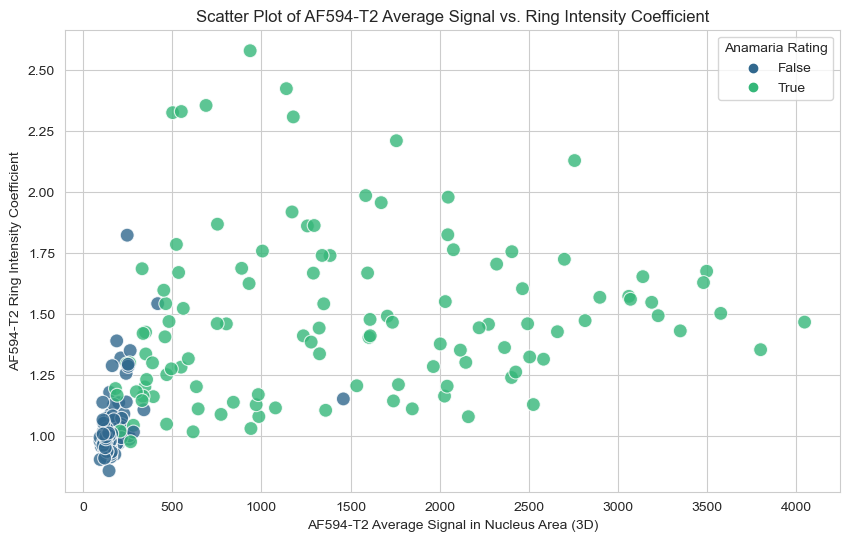

In [54]:
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Set the figure size
scatter_plot = sns.scatterplot(
    data=combined_df,
    x='AF594-T2 av_signal_in_nuc_area_3D',  # Specify the x-axis data
    y='AF594-T2 ring intensity coef',       # Specify the y-axis data
    hue='Anamaria',                         # Set the hue based on the 'Anamaria' column
    palette='viridis',                      # Choose a color palette
    s=100,                                  # Set the marker size
    alpha=0.8                               # Set the transparency of markers
)

# Set the title and labels of the plot
plt.title('Scatter Plot of AF594-T2 Average Signal vs. Ring Intensity Coefficient')
plt.xlabel('AF594-T2 Average Signal in Nucleus Area (3D)')
plt.ylabel('AF594-T2 Ring Intensity Coefficient')
plt.legend(title='Anamaria Rating')  # Customize the legend

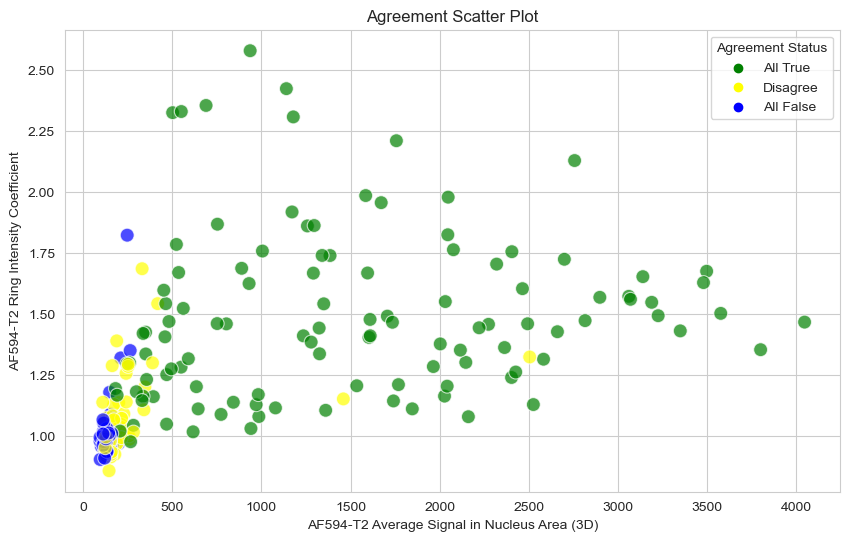

In [55]:
# Define the agreement category
def categorize_agreement(row):
    if row['Anamaria'] and row['Shayla'] and row['Sean']:
        return 'All True'
    elif not row['Anamaria'] and not row['Shayla'] and not row['Sean']:
        return 'All False'
    else:
        return 'Disagree'

combined_df['Agreement'] = combined_df.apply(categorize_agreement, axis=1)

# Set up the color palette manually
palette = {'All True': 'green', 'All False': 'blue', 'Disagree': 'yellow'}

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=combined_df,
    x='AF594-T2 av_signal_in_nuc_area_3D',  # Specify the x-axis data
    y='AF594-T2 ring intensity coef',       # Specify the y-axis data
    hue='Agreement',                        # Use the Agreement column for color
    palette=palette,                        # Set the color palette
    s=100,                                  # Marker size
    alpha=0.7                               # Transparency
)

# Set the title and labels of the plot
plt.title('Agreement Scatter Plot')
plt.xlabel('AF594-T2 Average Signal in Nucleus Area (3D)')
plt.ylabel('AF594-T2 Ring Intensity Coefficient')
plt.legend(title='Agreement Status')  # Customize the legend

# Show the plot
plt.show()


In [56]:
combined_df['coefficient_based'] = combined_df['AF594-T2 ring intensity coef'] >= RING_COEFF_CUT_OFF
combined_df.columns

Index(['Image_name', 'Time', 'Cell Type', 'LIV', 'Cisp', 'Cell_num',
       'Nucleus_volume, cubic_micrometre', 'Cy5-T1 av_signal_in_nuc_area_3D',
       'Cy5-T1 ring intensity coef', 'AF594-T2 av_signal_in_nuc_area_3D',
       'AF594-T2 ring intensity coef', 'AF488-T3 av_signal_in_nuc_area_3D',
       'AF488-T3 ring intensity coef', 'Img_num', 'Anamaria', 'Shayla', 'Sean',
       'Agreement', 'coefficient_based'],
      dtype='object')

### Random forest

In [61]:
X = combined_df.drop(['Anamaria', 'Shayla', 'Sean', 'Image_name', 'Img_num', 'Cell_num', 'Time','Cell Type',
                      'LIV', 'Cisp', 'coefficient_based', 'Agreement'], axis=1)  # Features
y = combined_df['Anamaria']  # Labels

# Preserve original labels for evaluation
original_labels = combined_df[['Shayla', 'Sean', 'coefficient_based']]

# Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# Add back the original labels to the test set for accuracy calculation
X_test_with_labels = X_test.join(original_labels)

# Initialize and train the Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Predict on the testing set
y_pred_rf = random_forest.predict(X_test)

# Calculate accuracy of Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Calculate accuracy of Shayla and Sean
accuracy_shayla = accuracy_score(y_test, X_test_with_labels['Shayla'])
accuracy_sean = accuracy_score(y_test, X_test_with_labels['Sean'])
accuracy_ring_coef = accuracy_score(y_test, X_test_with_labels['coefficient_based'])

# Calculate precision and recall for Random Forest
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

# Calculate precision and recall for Shayla and Sean
precision_shayla = precision_score(y_test, X_test_with_labels['Shayla'])
recall_shayla = recall_score(y_test, X_test_with_labels['Shayla'])

precision_sean = precision_score(y_test, X_test_with_labels['Sean'])
recall_sean = recall_score(y_test, X_test_with_labels['Sean'])

precision_ring_coef = precision_score(y_test, X_test_with_labels['coefficient_based'])
recall_ring_coef = recall_score(y_test, X_test_with_labels['coefficient_based'])

In [62]:
# Calculate precision and recall for Random Forest
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

# Calculate precision and recall for Shayla and Sean
precision_shayla = precision_score(y_test, X_test_with_labels['Shayla'])
recall_shayla = recall_score(y_test, X_test_with_labels['Shayla'])

precision_sean = precision_score(y_test, X_test_with_labels['Sean'])
recall_sean = recall_score(y_test, X_test_with_labels['Sean'])

precision_ring_coef = precision_score(y_test, X_test_with_labels['coefficient_based'])
recall_ring_coef = recall_score(y_test, X_test_with_labels['coefficient_based'])

# Print the precision and recall scores along with accuracy
print(f"Random Forest - Accuracy: {accuracy_rf:.2f}, Precision: {precision_rf:.2f}, Recall: {recall_rf:.2f}")
print(f"Shayla - Accuracy: {accuracy_shayla:.2f}, Precision: {precision_shayla:.2f}, Recall: {recall_shayla:.2f}")
print(f"Sean - Accuracy: {accuracy_sean:.2f}, Precision: {precision_sean:.2f}, Recall: {recall_sean:.2f}")
print(f"Ring Coef - Accuracy: {accuracy_ring_coef:.2f}, Precision: {precision_ring_coef:.2f}, Recall: {recall_ring_coef:.2f}")


Random Forest - Accuracy: 0.95, Precision: 1.00, Recall: 0.90
Shayla - Accuracy: 0.92, Precision: 0.87, Recall: 1.00
Sean - Accuracy: 0.91, Precision: 0.85, Recall: 1.00
Ring Coef - Accuracy: 0.84, Precision: 0.94, Recall: 0.74


In [59]:

# Extracting feature importances
feature_importances = random_forest.feature_importances_

# Create a DataFrame to view the features and their importances
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(features_df)

                             Feature  Importance
3  AF594-T2 av_signal_in_nuc_area_3D    0.442272
4       AF594-T2 ring intensity coef    0.297401
1    Cy5-T1 av_signal_in_nuc_area_3D    0.096350
0   Nucleus_volume, cubic_micrometre    0.072986
6       AF488-T3 ring intensity coef    0.037517
5  AF488-T3 av_signal_in_nuc_area_3D    0.034958
2         Cy5-T1 ring intensity coef    0.018517


In [60]:
# Calculate accuracy of Shayla and Sean for Whole SET
accuracy_shayla_whole = accuracy_score(combined_df['Anamaria'], combined_df['Shayla'])
accuracy_sean_whole = accuracy_score(combined_df['Anamaria'], combined_df['Sean'])
accuracy_sean_shayla = accuracy_score(combined_df['Anamaria'], combined_df['coefficient_based'])


# Calculate accuracy of Shayla and Sean for Whole SET
precision_shayla_whole = precision_score(combined_df['Anamaria'], combined_df['Shayla'])
precision_sean_whole = precision_score(combined_df['Anamaria'], combined_df['Sean'])
precision_sean_shayla = precision_score(combined_df['Anamaria'], combined_df['coefficient_based'])


recall_shayla_whole = recall_score(combined_df['Anamaria'], combined_df['Shayla'])
recall_sean_whole = recall_score(combined_df['Anamaria'], combined_df['Sean'])
recall_sean_shayla = recall_score(combined_df['Anamaria'], combined_df['coefficient_based'])

print(f"accuracy_shayla_whole: {accuracy_shayla_whole}, accuracy_sean_whole: {accuracy_sean_whole}, accuracy_sean_shayla: {accuracy_sean_shayla} "
      f"\n precision_shayla_whole: {precision_shayla_whole}, precision_sean_whole: {precision_sean_whole}, precision_sean_shayla: {precision_sean_shayla}"
      f"\n recall_shayla_whole: {recall_shayla_whole}, recall_sean_whole: {recall_sean_whole}, recall_sean_shayla: {recall_sean_shayla}")


accuracy_shayla_whole: 0.83203125, accuracy_sean_whole: 0.86328125, accuracy_sean_shayla: 0.8671875 
 precision_shayla_whole: 0.7295597484276729, precision_sean_whole: 0.7832167832167832, precision_sean_shayla: 0.91
 recall_shayla_whole: 1.0, recall_sean_whole: 0.9655172413793104, recall_sean_shayla: 0.7844827586206896
